## Things I learned/ worth remembering
- Debayering does not decrease the number of pixels --> always assumed it was a fancy way of making the pixels overlap each other so that effective nr of pixels is 4xactual pixels
- Preprocessing of exposure time is very odd -- is this some global property?
- One can set smaller and larger values than the min and max exposure times but thi leads to unforseen results

In [1]:
# First we calibrate against the Baader filter to get an approximate idea of how x is scaled
%load_ext autoreload
%autoreload 2
from calibrate import *
import matplotlib.pyplot as plt
import numpy as np
import skimage

## TODO
Dark calibration needs to work for all exposure lengths
Write interpolation

### Image Calibration
In this section the following calibrations are found within the Calibration class
- Bias
- Dark
- Lens distortion
- Rotation
- Crop bounds

Spectrum Images are also averaged

In [3]:
cal_dir = '/home/felix/KID_scripts/Spectroscope/cal_images'
cal = Calibration(cal_directory=cal_dir)

In [50]:
#   Only run this to generate new data takes 
# ~ 50s without Darks prob 70 with
im = cal.run_all_calibration(bias_img_dir='./cal_images/Bias/',
                        dark_img_dir=None,
                        lens_img_dir='./cal_images/Lens_distortion',
                        flat_img_dir='./cal_images/Flats',
                        rot='./cal_images/baader_filter/no_filter',
                        crop=True)

Compute lens calibration --> Code should be double checked
Problem with flat images minimum value is to small


In [4]:
#    If calibration was already done 
# Load the data
cal.load_calibration(cal_path=None) # None loads default location
cal.calib

{'mbias': '/home/felix/KID_scripts/Spectroscope/cal_images/computed_cal_files/master_bias.npy',
 'mdark': None,
 'mtx': [[77.68756660884115, 0.0, 1295.5],
  [0.0, 44.56274942463647, 971.5],
  [0.0, 0.0, 1.0]],
 'dist': [[-7.655316929042589e-15,
   -3.953874556280091e-10,
   9.552922808231535e-17,
   -4.648298203300493e-17,
   2.5723372316121737e-15]],
 'mflat': '/home/felix/KID_scripts/Spectroscope/cal_images/computed_cal_files/master_flat.npy',
 'Rotation': 2.0051046593435324,
 'Crop_y': [250, 664]}

max: 1.0, min:0.05941141251784645


Text(0.5, 1.0, 'Master Flat')

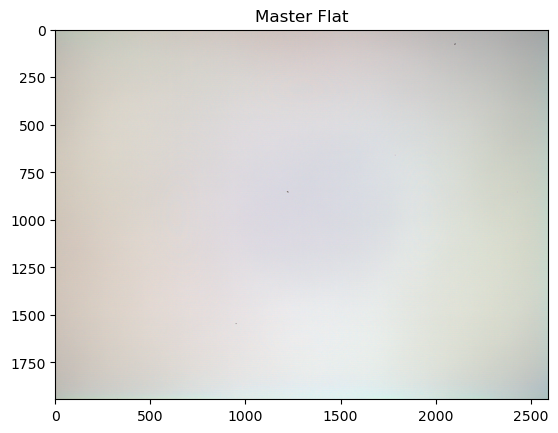

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(np.load(cal.calib['mflat']))
print('max: {}, min:{}'.format(np.load(cal.calib['mflat']).max(),np.load(cal.calib['mflat']).min()))
plt.title('Master Flat')

### Something is very weird about the readout! 

max: 550.11, min:0.0
Px corrupted: 10779711 out of 15116544


Text(0.5, 1.0, 'Master Bias')

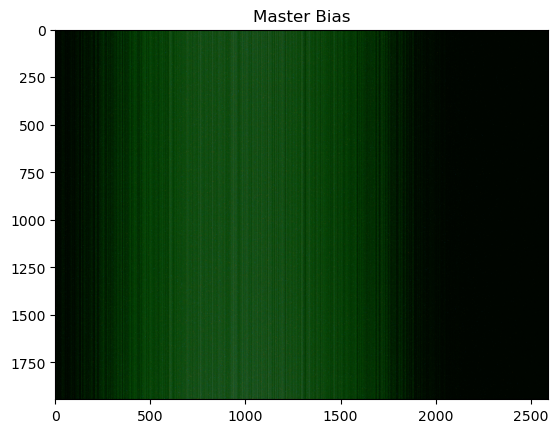

In [25]:
plt.imshow(np.load(cal.calib['mbias']).astype('uint8'))
print('max: {}, min:{}'.format(np.load(cal.calib['mbias']).max(),np.load(cal.calib['mbias']).min()))
print('Px corrupted: {} out of {}'.format(np.sum(np.load(cal.calib['mbias'])>0),np.load(cal.calib['mbias']).size))
plt.title('Master Bias')

In [41]:
# average filter and no filter data to improve calibration accuracy
# Note that none of the calibration files are given --> Class based prefered in this function only for debuggig
preprocess_images(img_dir='./cal_images/baader_filter/filter',out_img='./cal_images/baader_filter/With_filter.npy')
preprocess_images(img_dir='./cal_images/baader_filter/no_filter',out_img='./cal_images/baader_filter/Without_filter.npy')
preprocess_images(img_dir='./cal_images/650nm/',out_img='./cal_images/650nm.npy')


### Spectroscope calibration
- First computes transmission from filter
- Computes expected transmission from filter per color band
- Determines locaton of 650nm line (known source)
- Computes Spectrum

In [35]:
im_dat_wf = cal.process_image_with_calibration('./cal_images/baader_filter/With_filter.npy')
im_dat_nf = cal.process_image_with_calibration('./cal_images/baader_filter/Without_filter.npy')

4694353 values negative after bias for With_filter.npy
4694353 values negative after flat for With_filter.npy
4993312 values negative after lens correction for With_filter.npy
5475212 values negative after lens correction for With_filter.npy
1274930 values negative after lens correction for With_filter.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 0.0
3781965 values negative after bias for Without_filter.npy
3781965 values negative after flat for Without_filter.npy
3878320 values negative after lens correction for Without_filter.npy
4185872 values negative after lens correction for Without_filter.npy
1037435 values negative after lens correction for Without_filter.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 0.0


In [ ]:
# TODO Check that datatype conversions dont clip
# Add check mean and mean adaption to img chain
# Also check at what bps images are saved

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_90809/3051332088.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


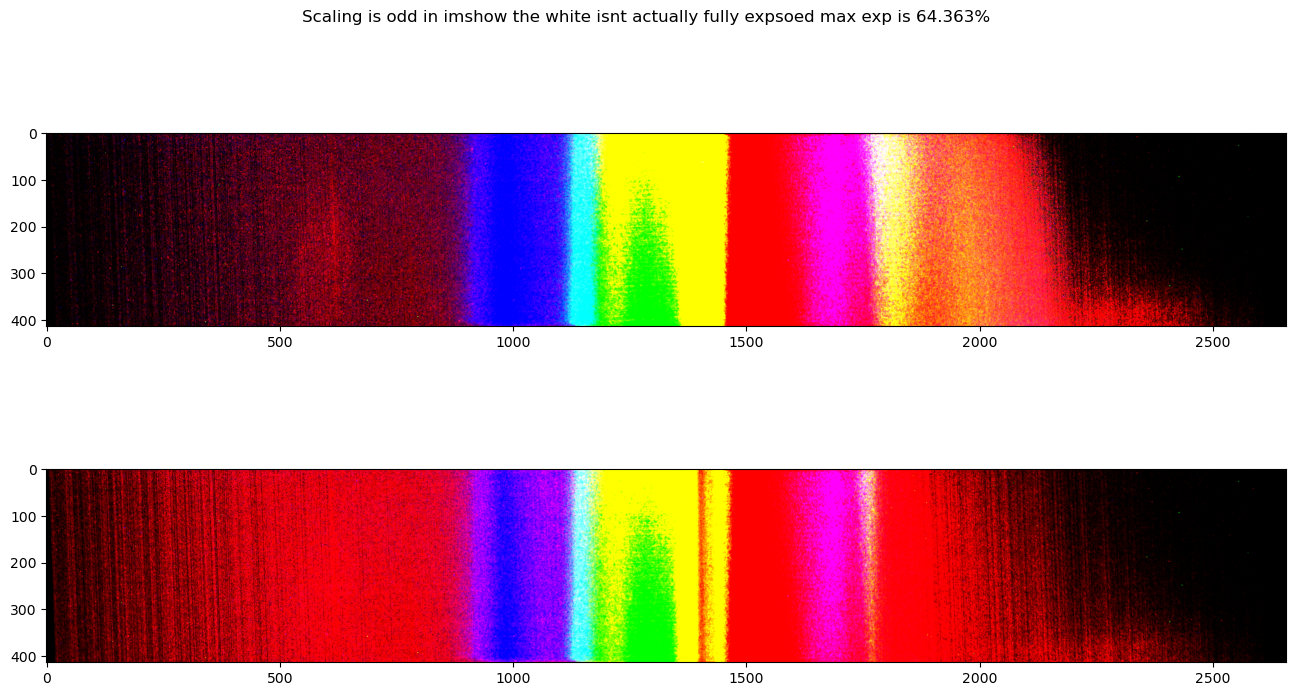

In [36]:

# The images were taken at infinite distance from the source (really short for this lens ) as the lens spectroscope combination is 
# set to infinite distance to measure the sky spectrum
# The source is a LUCIDE 49032/05/63 fillament lamp (LUCIDE G95) LED lamp 2200 K, with a makeshift light diffuser (bubble wrap)

# Some plotting
fig = plt.figure(figsize=(16,8))
axes = fig.subplots(nrows=2, ncols=1)
im = axes[0].imshow(im_dat_nf,vmin=0, vmax=2^16)
#cbar = axes[0].figure.colorbar(im, ax=axes[0])
#cbar.ax.set_ylabel('', rotation=-90, va="bottom")
axes[1].imshow(im_dat_wf,vmin=0, vmax=2^16)
fig.suptitle('Scaling is odd in imshow the white isnt actually fully expsoed max exp is {:.5}%'.format(np.max(im_dat_nf).astype(np.float64)/2**16*100))
fig.show()

In [37]:


#Compute transmission curve of combined effects lens+filter+spectral response of sensor
rel_change = 1-im_dat_wf/im_dat_nf

# Get rid of infinite arrising from 0 division (only comes if numerator is nonzero otherwise nan)
# When numerator is nonzero but denominator isnt the filter is leaving through more information --> Faulty data
# We will treat this data just like nan and set it to nan
print('\n{} total datapoints'.format(rel_change.size))
print('{} faulty datapoints : {:.2}%'.format(np.sum(np.isinf(rel_change)),np.sum(np.isinf(rel_change))/rel_change.size))
# The nan data arrises from the filter lens combination being opaque so we set it to 0 
print('{} opaque data points : {:.2}%\n'.format(np.sum(np.isnan(rel_change)), np.sum(np.isnan(rel_change))/rel_change.size))
print('{} negative data points : {:.2}%\n'.format(np.sum(rel_change<0), np.sum(np.isnan(rel_change))/rel_change.size))
rel_change[np.isnan(rel_change)] =0
rel_change[np.isinf(rel_change)] = np.nan # TODO: Fix



# We know that all divisions by zero will be opague to this wavelength so we can already predefine the individual wavlength acceptance range 



3301236 total datapoints
81760 faulty datapoints : 0.025%
1172729 opaque data points : 0.36%

715340 negative data points : 0.36%



/tmp/ipykernel_90809/2288211873.py:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_change = 1-im_dat_wf/im_dat_nf
/tmp/ipykernel_90809/2288211873.py:2: RuntimeWarning: invalid value encountered in true_divide
  rel_change = 1-im_dat_wf/im_dat_nf


/home/felix/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


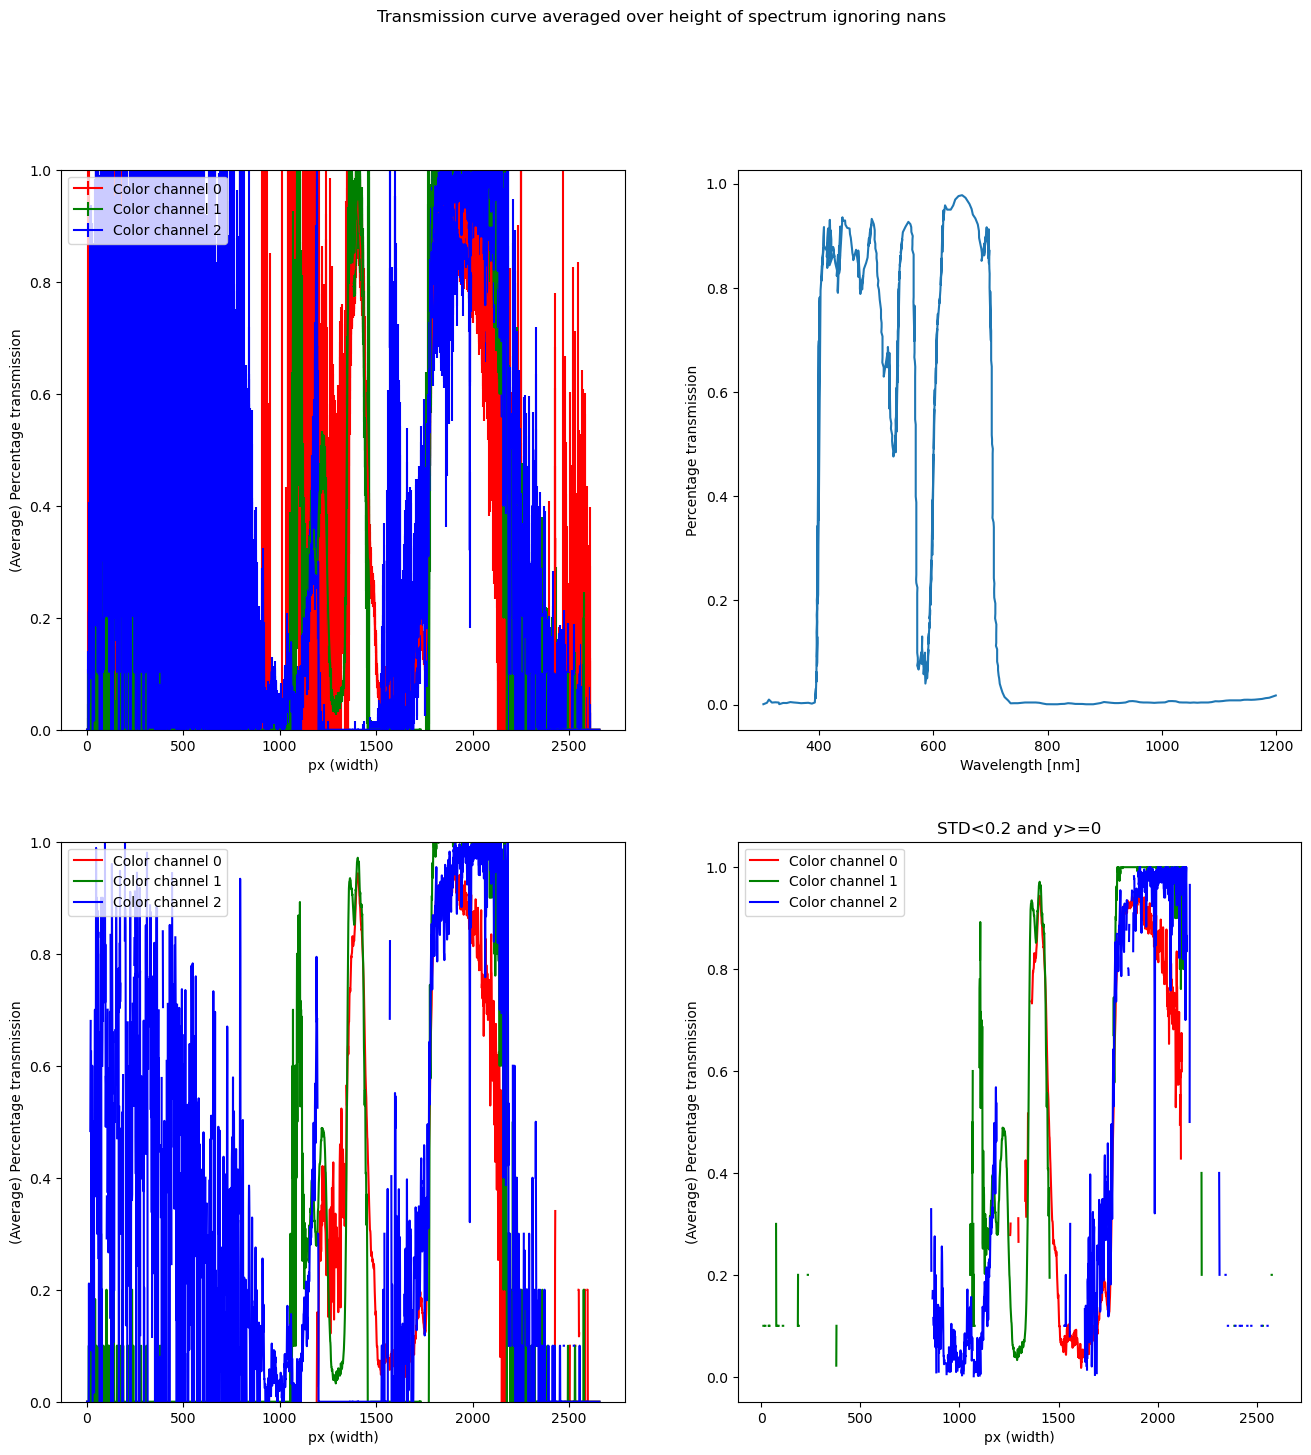

In [38]:
fig = plt.figure(figsize=(16,16))
axes = fig.subplots(nrows=2, ncols=2)

colors = {0:'Red', 1:'Green',2:'Blue'}

fig.suptitle('Transmission curve averaged over height of spectrum ignoring nans')
for i in range(0,3):
    # Select color channel
    c_dat = rel_change[::,::,i]
    c_dat = skimage.measure.block_reduce(c_dat, block_size=(10,1),func=np.mean,cval=0)
    # Get the mean value along each column and its standard deviation
    #y = np.nanmean(c_dat, axis=0)
    y=c_dat[10]
    y_std = np.nanstd(c_dat, axis=0)
    axes[1][0].plot(np.linspace(1,len(y),len(y)),y,c=colors[i],label='Color channel {}'.format(i))
    axes[0][0].errorbar(np.linspace(1,len(y),len(y)),y,c=colors[i],yerr=y_std,label='Color channel {}'.format(i))
    y[y_std>0.2] = np.nan
    y[y<=0] = np.nan
    axes[1][1].plot(np.linspace(1,len(y),len(y)),y,c=colors[i],label='Color channel {}'.format(i))
# Expected: Note that the x-scale will be wrong here just to get approximate ideas
baader_filter = get_baader_response()
axes[0][0].set_xlabel('px (width)')
axes[0][0].set_ylabel('(Average) Percentage transmission')
axes[1][0].set_xlabel('px (width)')
axes[1][0].set_ylabel('(Average) Percentage transmission')
axes[1][1].set_xlabel('px (width)')
axes[1][1].set_ylabel('(Average) Percentage transmission')
axes[1][1].set_title('STD<0.2 and y>=0')
interp_places = np.linspace(baader_filter[0,0],baader_filter[-1,0], len(y))
res = np.interp(interp_places, baader_filter[::,0], baader_filter[::,1])

axes[0][1].plot(baader_filter[::,0],baader_filter[::,1])
axes[0][1].set_xlabel('Wavelength [nm]')
axes[0][1].set_ylabel('Percentage transmission')
axes[0][0].legend()
axes[0][0].set_ylim(0,1)
axes[1][0].set_ylim(0,1)
axes[1][0].legend()
axes[1][1].legend()


plt.show()

wavelength_nm,red_qe,green_qe,blue_qe


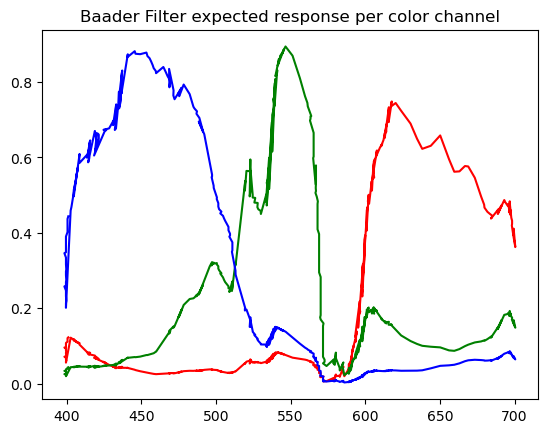

In [39]:
# We know the spectral response of the sensor in the visible spectrum so we compute the fit in this region to determine our x-scaling
import requests
r = requests.get('https://raw.githubusercontent.com/bluegreen-labs/raspberry_pi_camera_responses/master/Omnivision_OV5647_spectral_response.csv')
text = r.text.split('\n')
print(text[0])
spectral_response = [[float(j) for j in text[i].split(',')] for i in range(1,len(text)) if text[i]!='']
spectral_response = np.array(spectral_response, dtype=np.float64)
# Get the relative contribution to the expected filter response
baader_400 = np.where(baader_filter[::,0]>400)[0][0]
baader_700 = np.where(baader_filter[::,0]<=700)[0][-1]
spec_range = np.linspace(400,700,300)
# First find the relative response of each color band
response_red = np.interp(baader_filter[baader_400:baader_700:,0],spectral_response[::,0],spectral_response[::,1])/100 * baader_filter[baader_400:baader_700:,1]
response_green = np.interp(baader_filter[baader_400:baader_700:,0],spectral_response[::,0],spectral_response[::,2])/100 * baader_filter[baader_400:baader_700:,1]
response_blue = np.interp(baader_filter[baader_400:baader_700:,0],spectral_response[::,0],spectral_response[::,3])/100 * baader_filter[baader_400:baader_700:,1]

filter_spectral_response = [baader_filter[baader_400:baader_700:,0],response_green,response_blue,response_red]

plt.title('Baader Filter expected response per color channel')
plt.plot(baader_filter[baader_400:baader_700:,0],response_red,c='red')
plt.plot(baader_filter[baader_400:baader_700:,0],response_green,c='green')
plt.plot(baader_filter[baader_400:baader_700:,0],response_blue,c='blue')

4423603 values negative after bias for 650nm.npy
4423603 values negative after flat for 650nm.npy
4857937 values negative after lens correction for 650nm.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5800968 values negative after lens correction for 650nm.npy
1148321 values negative after lens correction for 650nm.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 0.0


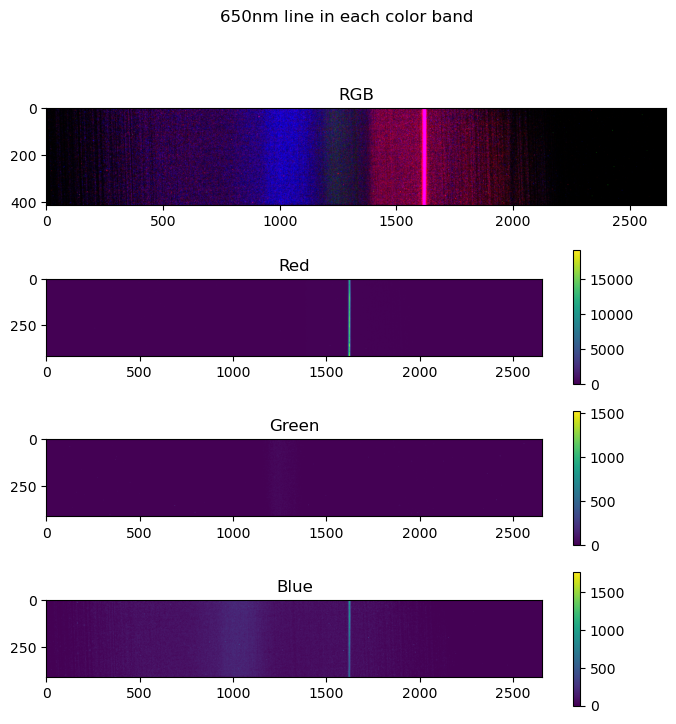

In [42]:
# Load and preprocess 650 nm line image
nm_650 = cal.process_image_with_calibration('./cal_images/650nm.npy')
colors = {0:'Red', 1:'Green',2:'Blue'}

fig = plt.figure(figsize=(8,8))
axes = fig.subplots(nrows=4, ncols=1)
fig.suptitle('650nm line in each color band')
axes[0].imshow(nm_650,)
axes[0].set_title('RGB')
for i in range(0,3):
    im=axes[i+1].imshow(nm_650[::,::,i])
    cbar = axes[i+1].figure.colorbar(im, ax=axes[i+1])
    cbar.ax.set_ylabel('', rotation=-90, va="bottom")
    axes[i+1].set_title(colors[i])



In [43]:
# Find max vertical average in red band
mean = np.mean(nm_650[::,::,0],axis=0)
# Variable to store pixel location of 650nm 
px_650nm = np.where(mean == np.max(mean))[0][0]
px_650nm

1623

## TODO: Fix Below

In [44]:
# Now we try to fit the measured response to the above

# The range over which interpolation will occure
spec_range = np.linspace(400,700,300)
# The interpolated data is relative to the baader positions so we reinterpolate
# NB Order in filter spectral response is GBR
response_green = np.interp(spec_range,filter_spectral_response[0],filter_spectral_response[1])
response_blue = np.interp(spec_range,filter_spectral_response[0],filter_spectral_response[2])
response_red = np.interp(spec_range,filter_spectral_response[0],filter_spectral_response[3])

filter_spectral_response = [spec_range,response_red,response_green,response_blue]

def map_poly(arr,coeffs):
    poly = lambda x: np.sum([coeffs[i]*(x**i) for i in range(len(coeffs))])
    poly = np.vectorize(poly)
    return poly(arr)

def find_fit(fit,color_data,pixel_pos, expected_distribution, poly_order=3):
    # Interpolate the observed response with respect to x position where each element is multiplied by some polynomial to determine the fit
    shifted_px_values = map_poly(pixel_pos,fit)
    # left and right return None for x outside of definition
    res = np.interp(spec_range, shifted_px_values, color_data,left=np.nan,right=np.nan)
    # RMS diff
    return np.sqrt(np.sum((expected_distribution - res)**2))


poly = []
colors = {0:'Red', 1:'Green',2:'Blue'}

for i in range(0,3):
    c_dat =rel_change[::,::,i]
    # Get the mean value along each column and its standard deviation
    y = np.nanmean(c_dat, axis=0)
    y_std = np.nanstd(c_dat, axis=0)
    y[y_std>0.2] = np.nan
    pixel_pos = np.linspace(0,len(y)-1,len(y))
    # Forx0 we do 650 - pixel pos so that pixel pos is centered on x=650
    # We start with what is epxected from the taylor expansion of x 
    res = scipy.optimize.minimize(find_fit,x0=[-(px_650nm-650),0,0,0],args=(y ,pixel_pos, filter_spectral_response[i+1], 5),method='CG')
    poly.append(res.x)



In [ ]:
print(poly)

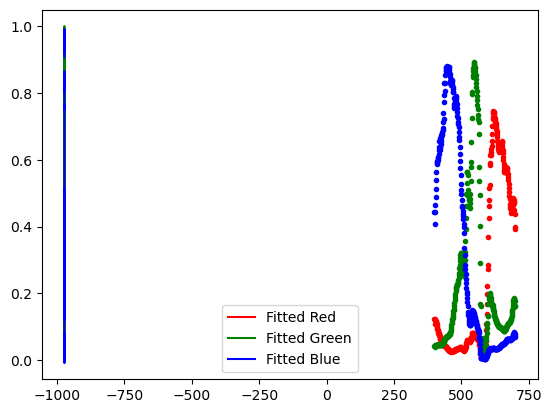

In [45]:
colors = {0:'Red', 1:'Green',2:'Blue'}

for i in range(0,3):
    c_dat =rel_change[::,::,i]
    shape = rel_change.shape
    # Get the mean value along each column and its standard deviation
    y = np.nanmean(c_dat, axis=0)
    y_std = np.nanstd(c_dat, axis=0)
    y[y_std>0.2] = np.nan
    pixel_pos = np.linspace(0,len(y)-1,len(y))
    x = map_poly(pixel_pos,poly[0])
    plt.plot(x,y,c=colors[i],label='Fitted {}'.format(colors[i]))
    
plt.scatter(spec_range,response_red,marker='.',c='red')
plt.scatter(spec_range,response_green,marker='.',c='green')
plt.scatter(spec_range,response_blue,marker='.',c='blue')
plt.legend()

In [33]:
poly

[array([-177.41207104,    2.88792896,    2.58792896,    2.58792896]),
 array([-139.41207104,    2.88792896,    2.58792896,    2.58792896]),
 array([-140.41207104,    2.88792896,    2.58792896,    2.58792896])]

In [28]:
px_650

[830, 792, 793]